# Emissions and Fluxes

In [1]:
# Import Modules
import pandas as pd
import xarray as xr
import numpy as np
%matplotlib inline
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
import matplotlib.pyplot as plt
import cmocean as cm
import datetime

In [2]:
# Scenarios and Models and Directories

# CNRM has river carbon inputs and its flux is 0.78PG/YR lower than other models

root_dir = "/data/artemis/simulations/CMIP6"
ssp126_dir = f"{root_dir}/SSP126"
ssp119_dir = f"{root_dir}/SSP119"
ssp245_dir = f"{root_dir}/SSP245"
ssp534_dir = f"{root_dir}/SSP534"
ssp585_dir = f"{root_dir}/SSP585"  # Same as SSP5-34 until 2040

scenarios = ['ssp126','ssp119','ssp245','ssp534','ssp585']
scen_disp = ['SSP1-26','SSP1-19','SSP2-45','SSP5-34','SSP5-85']
scen_fold = ['SSP126','SSP119','SSP245','SSP534','SSP585']
scen_colors = ['cyan','blue','green','orange','red'] # hottest most red here

# Only those with several ensemble members used here:
# CNRM not used because of river carbon inputs into ocean:
models = np.array([["ACCESS-ESM1-5","MIROC-ES2L","IPSL-CM6A-LR","MPI-ESM1-2-LR","UKESM1-0-LL","CNRM-ESM2-1"], #ssp1-26
                  ["MIROC-ES2L","CanESM5","IPSL-CM6A-LR","UKESM1-0-LL","CNRM-ESM2-1"], # ssp1-19
                  ["ACCESS-ESM1-5","IPSL-CM6A-LR","MPI-ESM1-2-LR","MPI-ESM1-2-HR","NorESM2-MM","UKESM1-0-LL","CNRM-ESM2-1"], # ssp2-45
                  ["IPSL-CM6A-LR","UKESM1-0-LL","CNRM-ESM2-1"], #ssp5-34 "CanESM5","CESM2-WACCM",
                  ["ACCESS-ESM1-5","IPSL-CM6A-LR","MPI-ESM1-2-LR","UKESM1-0-LL","CNRM-ESM2-1"]],dtype=object) # ssp5-85

lwidths = np.array([[1,2,2,1,2,1],
                   [1,1,2,2,2],
                   [1,2,2,1,1,2,1],
                   [2,2,2],  #[1,1,2,2,2],
                   [1,2,1,2,2]],dtype=object)

In [3]:
# Emissions
cmip226_emit_tmp = np.array([39152.726,39804.013,34734.424,26509.183,17963.539,10527.979,4476.328,-3285.043,-8385.183,-8617.786]) 
cmip245_emit_tmp = np.array([39148.758,40647.530,43476.063,44252.900,43462.190,40196.485,35235.434,26838.373,16324.392,9682.859])
cmip119_emit_tmp = np.array([39152.726,39693.726,22847.271,10475.089,2050.362,-1525.978,-4476.970,-7308.783,-10565.023,-13889.788])
cmip585_emit_tmp = np.array([39152.726,43712.349,55296.583,68775.698,83298.220,100338.606,116805.249,129647.035,130576.239,126287.310])
cmip534_emit_tmp = np.array([39152.726,43712.629,55300.017,68774.628,50319.095,16582.668,-5768.062,-14855.333,-18556.245,-20311.382])

emit_yrs = np.array([2015,2020,2030,2040,2050,2060,2070,2080,2090,2100])

# Need to interpolate linearly from decades to years #
ssp126_emit = np.interp(range(2015,2101),emit_yrs,cmip226_emit_tmp)
ssp245_emit = np.interp(range(2015,2101),emit_yrs,cmip245_emit_tmp)
ssp119_emit = np.interp(range(2015,2101),emit_yrs,cmip119_emit_tmp)
ssp585_emit = np.interp(range(2015,2101),emit_yrs,cmip585_emit_tmp)
ssp534_emit = np.interp(range(2015,2101),emit_yrs,cmip534_emit_tmp)

emissions = np.empty(shape=(5,86))
emissions[0,:]=ssp126_emit
emissions[1,:]=ssp119_emit
emissions[2,:]=ssp245_emit
emissions[3,:]=ssp534_emit
emissions[4,:]=ssp585_emit

emissions = emissions / 1000 * (12/44) # Gt Carbon

demit = pd.DataFrame(index=range(2015,2101))
demit['ssp126'] = emissions[0,:]
demit['ssp119'] = emissions[1,:]
demit['ssp245'] = emissions[2,:]
demit['ssp534'] = emissions[3,:]
demit['ssp585'] = emissions[4,:]

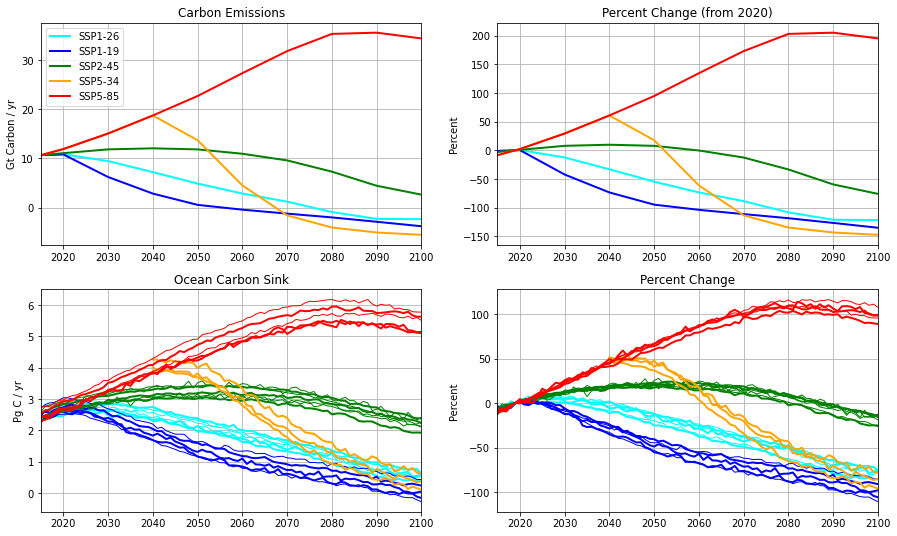

In [5]:
# Plot up emissions (raw and percent from 2020) vs fluxes (raw and percent from 2020)

fig,ax = plt.subplots(2,2,figsize=(15,9))
s = 0
for scen in scenarios:
    ax[0,0].plot(range(2015,2101),emissions[s,:],color=scen_colors[s],label=scen_disp[s],linewidth=2)
    ax[0,1].plot(range(2015,2101),(emissions[s,:]-emissions[s,4])/emissions[s,4]*100,color=scen_colors[s],linewidth=2)
    
    # Loop on models
    m = 0
    for mod in models[s]:
        linew = lwidths[s]
        
        if (scen=="ssp534"):
            ds = xr.load_dataset(f"{root_dir}/SSP585/processed/fgco2_Omon_{mod}_ssp585_annualflux_201501-210012.nc")
            fx = ds.flux[0:25]
            del ds
            
            ds = xr.load_dataset(f"{root_dir}/{scen_fold[s]}/processed/fgco2_Omon_{mod}_{scen}_annualflux_204001-210012.nc")
            fx2 = ds.flux
            
            if mod == "CNRM-ESM2-1":
                fx = fx + 0.78
                fx2 = fx2 + 0.78
            ax[1,0].plot(fx2.year,fx2,color=scen_colors[s],label="",linewidth=linew[m])
            ax[1,1].plot(fx2.year,(fx2-fx[4])/fx[4]*100,color=scen_colors[s],label="",linewidth=linew[m])  # Adjust to SSP5-85 cutoff
            del ds,fx
            
        else:
            
            ds = xr.load_dataset(f"{root_dir}/{scen_fold[s]}/processed/fgco2_Omon_{mod}_{scen}_annualflux_201501-210012.nc")
            fx = ds.flux
            if mod == "CNRM-ESM2-1":
                fx = fx + 0.78
            ax[1,0].plot(fx.year,fx,color=scen_colors[s],label="",linewidth=linew[m])
            ax[1,1].plot(fx.year,(fx-fx[4])/fx[4]*100,color=scen_colors[s],label="",linewidth=linew[m])
            del ds,fx
        m +=1
    s +=1

ax[0,0].set_title("Carbon Emissions")
ax[0,0].legend()
ax[0,0].grid(True)
ax[0,0].set_ylabel("Gt Carbon / yr")
ax[0,0].set_xlim(2015,2100)

ax[0,1].set_title("Percent Change (from 2020)")
ax[0,1].grid(True)
ax[0,1].set_ylabel("Percent")
ax[0,1].set_xlim(2015,2100)

ax[1,1].set_title("Percent Change")
ax[1,1].grid(True)
ax[1,1].set_ylabel("Percent")
ax[1,1].set_xlim(2015,2100)

ax[1,0].set_title("Ocean Carbon Sink")
ax[1,0].grid(True)
ax[1,0].set_ylabel("Pg C / yr")
ax[1,0].set_xlim(2015,2100)

#fig.savefig("/data/artemis/workspace/vbennington/CMIP6_figs/emissions_sinks.jpg")
plt.show()

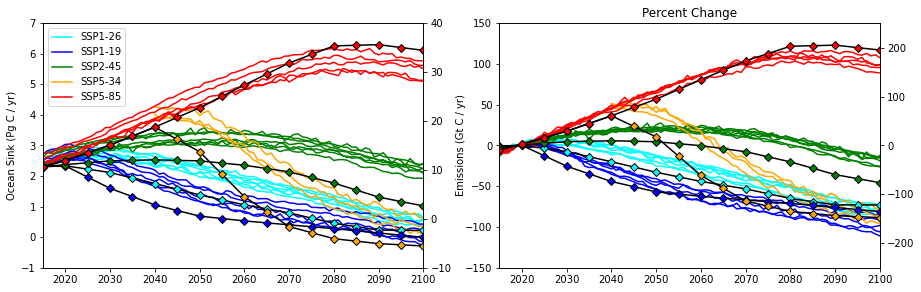

In [6]:
# Plot up emissions (raw and percent from 2020) vs fluxes (raw and percent from 2020)

fig,ax = plt.subplots(1,2,figsize=(15,4.5))
s = 0
ax2=ax[0].twinx()
ax3=ax[1].twinx()

for scen in scenarios:
    #ax[0,0].plot(range(2015,2101),emissions[s,:],color=scen_colors[s],label=scen_disp[s],linewidth=2)
    #ax[0,1].plot(range(2015,2101),(emissions[s,:]-emissions[s,4])/emissions[s,4]*100,color=scen_colors[s],linewidth=2)
    
    ax2.plot(range(2015,2101),emissions[s,:],label=scen_disp[s],marker="D",color='black',markerfacecolor=scen_colors[s],markevery=5)
    ax3.plot(range(2015,2101),(emissions[s,:]-emissions[s,4])/emissions[s,4]*100,color='black',marker="D",markerfacecolor=scen_colors[s],markevery=5)
    ax2.set_ylabel("Emissions (Gt C / yr)",color='black')
    ax2.set_ylim(-10,40)
    ax3.set_ylim(-250,250)
    #plt.plot(xa, ya, color='lightcoral', marker='D', markeredgecolor='black')
    # Loop on models
    m = 0
    for mod in models[s]:
        
        if (scen=="ssp534"):
            ds = xr.load_dataset(f"{root_dir}/SSP585/processed/fgco2_Omon_{mod}_ssp585_annualflux_201501-210012.nc")
            fx = ds.flux[0:25]
            del ds
            
            ds = xr.load_dataset(f"{root_dir}/{scen_fold[s]}/processed/fgco2_Omon_{mod}_{scen}_annualflux_204001-210012.nc")
            fx2 = ds.flux
            
            if mod == "CNRM-ESM2-1":
                fx = fx + 0.78
                fx2 = fx2 + 0.78
            if m==0:
                ax[0].plot(fx2.year,fx2,color=scen_colors[s],label=scen_disp[s])
                ax[1].plot(fx2.year,(fx2-fx[4])/fx[4]*100,color=scen_colors[s],label=scen_disp[s])  # Adjust to SSP5-85 cutoff
            else:
                ax[0].plot(fx2.year,fx2,color=scen_colors[s],label="")
                ax[1].plot(fx2.year,(fx2-fx[4])/fx[4]*100,color=scen_colors[s],label="")  # Adjust to SSP5-85 cutoff
            
            del ds,fx
            
        else:
            
            ds = xr.load_dataset(f"{root_dir}/{scen_fold[s]}/processed/fgco2_Omon_{mod}_{scen}_annualflux_201501-210012.nc")
            fx = ds.flux
            if mod == "CNRM-ESM2-1":
                fx = fx + 0.78
            if m == 0:
                ax[0].plot(fx.year,fx,color=scen_colors[s],label=scen_disp[s])
                ax[1].plot(fx.year,(fx-fx[4])/fx[4]*100,color=scen_colors[s],label=scen_disp[s])
            else:
                ax[0].plot(fx.year,fx,color=scen_colors[s],label="")
                ax[1].plot(fx.year,(fx-fx[4])/fx[4]*100,color=scen_colors[s],label="")
            del ds,fx
        m +=1
    s +=1

ax[0].legend()
#ax[0].grid(True)
ax[0].set_ylabel("Gt Carbon / yr")
ax[0].set_xlim(2015,2100)
ax[0].set_ylim(-1,7)

ax[1].set_title("Percent Change (from 2020)")
#ax[1].grid(True)
ax[1].set_xlim(2015,2100)

ax[1].set_title("Percent Change")
#ax[1].grid(True)
ax[1].set_xlim(2015,2100)
ax[1].set_ylim(-150,150)

ax[0].set_ylabel("Ocean Sink (Pg C / yr)")
#ax[0].grid(True)
#ax[0,0].set_ylabel("Pg C / yr")
ax[0].set_xlim(2015,2100)

fig.savefig("/data/artemis/workspace/vbennington/CMIP6_figs/emissions_sinks_in_one.jpg")
plt.show()

In [7]:
# Get the annual fluxes into a dataframe:

dflux = pd.DataFrame()

dflux['ssp119'] = xr.open_dataset(f"/data/artemis/simulations/CMIP6/SSP119/processed/ssp119_allmodel_annualflux_201501-210012.nc").flux
dflux['ssp126'] = xr.open_dataset(f"/data/artemis/simulations/CMIP6/SSP126/processed/ssp126_allmodel_annualflux_201501-210012.nc").flux
dflux['ssp245'] = xr.open_dataset(f"/data/artemis/simulations/CMIP6/SSP245/processed/ssp245_allmodel_annualflux_201501-210012.nc").flux
dflux['ssp585'] = xr.open_dataset(f"/data/artemis/simulations/CMIP6/SSP585/processed/ssp585_allmodel_annualflux_201501-210012.nc").flux
dflux['year'] = range(2015,2101)
dflux=dflux.set_index(dflux['year'], drop=True)
tmp = xr.open_dataset(f"/data/artemis/simulations/CMIP6/SSP534/processed/ssp534_allmodel_annualflux_204001-210012.nc").flux
tmpf = xr.open_dataset(f"/data/artemis/simulations/CMIP6/SSP585/processed/ssp585_allmodel_annualflux_201501-210012.nc").flux
tmpf[25:86]=tmp
dflux['ssp534'] = tmpf

ssp126
ssp245
ssp119
ssp534
ssp585


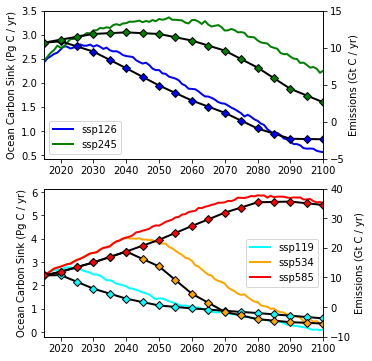

In [10]:
# Plot up emissions (raw and percent from 2020) vs fluxes (raw and percent from 2020)

fig,ax = plt.subplots(2,1,figsize=(5,6))
s = 0
ax2=ax[0].twinx()
ax3=ax[1].twinx()

s_colors = ['blue','green'] # hottest most red here
s=0
for scen in ['ssp126','ssp245']:
    
    print(scen)
    flux = dflux[f'{scen}'].values
    yrs = dflux['year'].values
    fi = (flux == flux.max())
    #print(f"Peak Flux = {yrs[fi]}")
    emit = demit[f'{scen}']
    fie = (emit == emit.max())
    #print(f"Peak Emit = {yrs[fie]}")
    
    ax[0].plot(range(2015,2101),flux,color=s_colors[s],linewidth=2,label=f"{scen}")
    
    ax2.plot(range(2015,2101),demit[f'{scen}'],marker="D",linewidth=2,color='black',markerfacecolor=s_colors[s],markevery=5)
    ax2.set_ylabel("Emissions (Gt C / yr)",color='black')
    ax2.set_ylim(-5,15)
    ax2.set_xlim(2015,2100)
    ax[0].set_xlim(2015,2100)
    ax[0].set_ylabel("Ocean Carbon Sink (Pg C / yr)")
    ax[0].legend()    
    s+=1

s = 0
s_colors = ['cyan','orange','red']
for scen in ['ssp119','ssp534','ssp585']:
    
    print(scen)
    flux = dflux[f'{scen}'].values
    yrs = dflux['year'].values
    fi = (flux == flux.max())
    emit = demit[f'{scen}']
    fie = (emit == emit.max())
    
    ax[1].plot(range(2015,2101),flux,color=s_colors[s],linewidth=2,label=f"{scen}")
    ax3.plot(range(2015,2101),demit[f'{scen}'],linewidth=2,marker="D",color='black',markerfacecolor=s_colors[s],markevery=5)
    ax3.set_ylim(-10,40)
    ax3.set_ylabel("Emissions (Gt C / yr)",color='black')
    ax3.set_xlim(2015,2100)
    ax[1].set_xlim(2015,2100)
    ax[1].set_ylabel("Ocean Carbon Sink (Pg C / yr)")
    ax[1].legend() 
    s+=1
    
fig.savefig("/data/artemis/workspace/vbennington/CMIP6_figs/flux_futures_fig1.jpg")
plt.show()

# For each model, scatter 2020 flux vs Peak Flux

In [11]:
scat_models = np.array([['CanESM5','CNRM-ESM2-1','GFDL-ESM4','IPSL-CM6A-LR','MIROC-ES2L','UKESM1-0-LL'], #ssp119
                       ['ACCESS-ESM1-5','CNRM-ESM2-1','GFDL-ESM4','IPSL-CM6A-LR','MPI-ESM1-2-LR','UKESM1-0-LL','MIROC-ES2L'],#ssp126
                       ['ACCESS-ESM1-5','CNRM-ESM2-1','GFDL-ESM4','IPSL-CM6A-LR','MPI-ESM1-2-LR','UKESM1-0-LL','NorESM2-MM'], #ssp245
                       ['CNRM-ESM2-1','IPSL-CM6A-LR','UKESM1-0-LL'], #ssp534 (need 5-85 for 2020)
                       ['ACCESS-ESM1-5','CNRM-ESM2-1','GFDL-ESM4','IPSL-CM6A-LR','MPI-ESM1-2-HR','UKESM1-0-LL']],dtype=object) #ssp5-85

scat_scen = ['ssp119','ssp126','ssp245','ssp534','ssp585']
scat_fold = ['SSP119','SSP126','SSP245','SSP534','SSP585']
scat_col = ['cyan','blue','green','orange','red']
pkyrs = [2022,2026,2053,2040,2080]


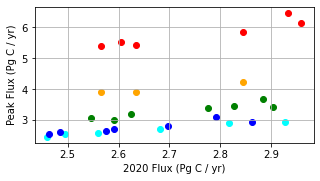

In [12]:
fig = plt.figure(figsize=(5,2.5))

for s in range(0,5):
    mod_dir = f"/data/artemis/simulations/CMIP6/{scat_fold[s]}/processed"
    
    for mod in scat_models[s]:
        if s==3:
            tmp = xr.open_dataset(f"{mod_dir}/fgco2_Omon_{mod}_{scat_scen[s]}_annualflux_204001-210012.nc").flux
            tmp2 = xr.open_dataset(f"/data/artemis/simulations/CMIP6/SSP585/processed/fgco2_Omon_{mod}_ssp585_annualflux_201501-210012.nc").flux
            if mod == "CNRM-ESM2-1":
                tmp = tmp + 0.78
                tmp2 = tmp2 + 0.78
            plt.scatter(tmp2.sel(year=slice(2015,2024)).mean(),tmp.sel(year=slice(pkyrs[s],pkyrs[s]+5)).mean(),color=scat_col[s])                       
            #plt.scatter(tmp2.sel(year=2020),tmp.max(),color=scat_col[s])                       
                                   
        else:
            tmp = xr.open_dataset(f"{mod_dir}/fgco2_Omon_{mod}_{scat_scen[s]}_annualflux_201501-210012.nc").flux
            if mod == "CNRM-ESM2-1":
                tmp = tmp + 0.78
            plt.scatter(tmp.sel(year=slice(2015,2024)).mean(),tmp.sel(year=slice(pkyrs[s]-5,pkyrs[s]+5)).mean(),color=scat_col[s])
            #plt.scatter(tmp.sel(year=2020),tmp.max(),color=scat_col[s])

plt.xlabel("2020 Flux (Pg C / yr)")
plt.ylabel("Peak Flux (Pg C / yr)")
plt.grid(True)
fig.savefig("/data/artemis/workspace/vbennington/CMIP6_figs/flux_futures_scatter_2020_peak.jpg")
plt.show()

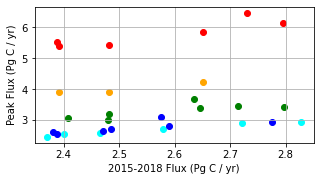

In [14]:
fig = plt.figure(figsize=(5,2.5))

for s in range(0,5):
    mod_dir = f"/data/artemis/simulations/CMIP6/{scat_fold[s]}/processed"
    
    for mod in scat_models[s]:
        if s==3:
            tmp = xr.open_dataset(f"{mod_dir}/fgco2_Omon_{mod}_{scat_scen[s]}_annualflux_204001-210012.nc").flux
            tmp2 = xr.open_dataset(f"/data/artemis/simulations/CMIP6/SSP585/processed/fgco2_Omon_{mod}_ssp585_annualflux_201501-210012.nc").flux
            if mod == "CNRM-ESM2-1":
                tmp = tmp + 0.78
                tmp2 = tmp2 + 0.78
            plt.scatter(tmp2.sel(year=slice(2015,2018)).mean(),tmp.sel(year=slice(pkyrs[s],pkyrs[s]+5)).mean(),color=scat_col[s])                       
            #plt.scatter(tmp2.sel(year=2020),tmp.max(),color=scat_col[s])                       
                                   
        else:
            tmp = xr.open_dataset(f"{mod_dir}/fgco2_Omon_{mod}_{scat_scen[s]}_annualflux_201501-210012.nc").flux
            if mod == "CNRM-ESM2-1":
                tmp = tmp + 0.78
            plt.scatter(tmp.sel(year=slice(2015,2018)).mean(),tmp.sel(year=slice(pkyrs[s]-5,pkyrs[s]+5)).mean(),color=scat_col[s])
            #plt.scatter(tmp.sel(year=2020),tmp.max(),color=scat_col[s])

plt.xlabel("2015-2018 Flux (Pg C / yr)")
plt.ylabel("Peak Flux (Pg C / yr)")
plt.grid(True)
fig.savefig("/data/artemis/workspace/vbennington/CMIP6_figs/flux_futures_scatter_2015-2018_peak.jpg")
plt.show()

In [15]:
magic_aco2 = xr.load_dataset("/data/artemis/simulations/Magic7/magicc7-ar6-wg1-tuning-carbon-cycle-output_v20210701.nc").co2s
# 451 years, grab 2015 to 2100:
magic_atm = magic_aco2[:,:,165:251].mean("ensemble_member")

/home/vbennington/.conda/envs/xesmf_env/lib/python3.7/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/vbennington/.conda/envs/xesmf_env/lib/python3.7/site-packages/numpy/core/_asarray.py:102: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [16]:
print(magic_aco2.scenario)

<xarray.DataArray 'scenario' (scenario: 8)>
array(['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp434', 'ssp460',
       'ssp534-over', 'ssp585'], dtype=object)
Coordinates:
  * scenario  (scenario) object 'ssp119' 'ssp126' ... 'ssp534-over' 'ssp585'


ssp126
ssp245
ssp119
Peak Flux = [2022]
ssp534
Peak Flux = [2040]
ssp585
Peak Flux = [2080]


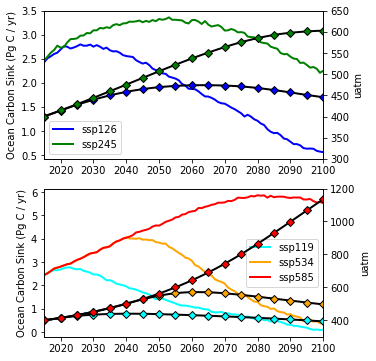

In [17]:
fig,ax = plt.subplots(2,1,figsize=(5,6))
s = 0
ax2=ax[0].twinx()
ax3=ax[1].twinx()

s_colors = ['blue','green'] # hottest most red here
s=0
for scen in ['ssp126','ssp245']:
    
    print(scen)
    flux = dflux[f'{scen}'].values
    yrs = dflux['year'].values
    fi = (flux == flux.max())
    #print(f"Peak Flux = {yrs[fi]}")
    if s==0:
        atm = magic_atm[1,:]
    if scen=='ssp245':
        atm = magic_atm[2,:]
    fie = (magic_atm[s+1,:] == magic_atm[s+1,:].max())
    #print(f"Peak Atmo = {yrs[fie]}")
    
    ax[0].plot(range(2015,2101),flux,color=s_colors[s],linewidth=2,label=f"{scen}")
    
    ax2.plot(range(2015,2101),atm,marker="D",linewidth=2,color='black',markerfacecolor=s_colors[s],markevery=5)
    ax2.set_ylabel("uatm",color='black')
    ax2.set_ylim(300,650)
    ax2.set_xlim(2015,2100)
    ax[0].set_xlim(2015,2100)
    ax[0].set_ylabel("Ocean Carbon Sink (Pg C / yr)")
    ax[0].legend()    
    s+=1

s = 0
s_colors = ['cyan','orange','red']
for scen in ['ssp119','ssp534','ssp585']:
    
    print(scen)
    flux = dflux[f'{scen}'].values
    yrs = dflux['year'].values
    fi = (flux == flux.max())
    print(f"Peak Flux = {yrs[fi]}")
    if s==0:
        atm = magic_atm[0,:]
    elif s==1:
        atm = magic_atm[6,:]
    elif s==2:
        atm = magic_atm[7,:]
    
    ax[1].plot(range(2015,2101),flux,color=s_colors[s],linewidth=2,label=f"{scen}")
    ax3.plot(range(2015,2101),atm,linewidth=2,marker="D",color='black',markerfacecolor=s_colors[s],markevery=5)
    ax3.set_ylim(300,1200)
    ax3.set_ylabel("uatm",color='black')
    ax3.set_xlim(2015,2100)
    ax[1].set_xlim(2015,2100)
    ax[1].set_ylabel("Ocean Carbon Sink (Pg C / yr)")
    ax[1].legend() 
    s+=1
    
fig.savefig("/data/artemis/workspace/vbennington/CMIP6_figs/flux_futures_atmCO2_sinks.jpg")
plt.show()

ssp126
ssp245
ssp119
ssp534
ssp585


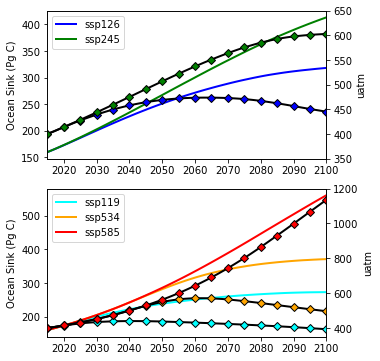

In [18]:
# 2014 Cumulative Emissions = 602.18 ((Friedlingstien et al. 2020, ESSD))
# 2014 Cumulative Ocean Sink = 157.5

fig,ax = plt.subplots(2,1,figsize=(5,6))
s = 0
ax2=ax[0].twinx()
ax3=ax[1].twinx()

s_colors = ['blue','green'] # hottest most red here
s=0
for scen in ['ssp126','ssp245']:
    
    print(scen)
    tmpflux = dflux[f'{scen}'].values
    flux = 0*np.empty(shape=(len(tmpflux)))
    flux[0] = tmpflux[0] + 157.5
    for i in range(1,len(flux)):
        flux[i] = flux[i-1]+tmpflux[i]
    yrs = dflux['year'].values
    if s==0:
        atm = magic_atm[1,:]
    if scen=='ssp245':
        atm = magic_atm[2,:]
    
    ax[0].plot(range(2015,2101),flux,color=s_colors[s],linewidth=2,label=f"{scen}")
    
    ax2.plot(range(2015,2101),atm,marker="D",linewidth=2,color='black',markerfacecolor=s_colors[s],markevery=5)
    ax2.set_ylabel("uatm",color='black')
    ax2.set_ylim(350,650)
    ax2.set_xlim(2015,2100)
    ax[0].set_xlim(2015,2100)
    ax[0].set_ylabel("Ocean Sink (Pg C)")
    ax[0].legend()    
    s+=1
    del flux, tmpflux
    
s = 0
s_colors = ['cyan','orange','red']
for scen in ['ssp119','ssp534','ssp585']:
    
    print(scen)
    tmpflux = dflux[f'{scen}'].values
    flux = 0*np.empty(shape=(len(tmpflux)))
    flux[0] = tmpflux[0] + 157.5
    for i in range(1,len(flux)):
        flux[i] = flux[i-1]+tmpflux[i]
    if s==0:
        atm = magic_atm[0,:]
    elif s==1:
        atm = magic_atm[6,:]
    elif s==2:
        atm = magic_atm[7,:]
    
    ax[1].plot(range(2015,2101),flux,color=s_colors[s],linewidth=2,label=f"{scen}")
    ax3.plot(range(2015,2101),atm,linewidth=2,marker="D",color='black',markerfacecolor=s_colors[s],markevery=5)
    ax3.set_ylim(350,1200)
    ax3.set_ylabel("uatm",color='black')
    ax3.set_xlim(2015,2100)
    ax[1].set_xlim(2015,2100)
    ax[1].set_ylabel("Ocean Sink (Pg C)")
    ax[1].legend() 
    s+=1
    del flux, tmpflux
fig.savefig("/data/artemis/workspace/vbennington/CMIP6_figs/cumul_flux_futures_atmCO2_sinks.jpg")
plt.show()